In [1]:
import numpy as np
import dask.dataframe as dd
import pandas as pd
import seaborn as sns
from dask.distributed import Client
from matplotlib import pyplot as plt

In [2]:
data_path = "../processed_data/" + '2perc_sample.parquet'

In [3]:
# start Dask client

client = Client()

In [5]:
df = dd.read_parquet(data_path, engine='fastparquet')

In [6]:
df.pickup_datetime = df.pickup_datetime.astype('datetime64[ns]')
df.dropoff_datetime = df.dropoff_datetime.astype('datetime64[ns]')

In [7]:
df["pickup_year"] = df.pickup_datetime.dt.year
df["dropoff_year"] = df.dropoff_datetime.dt.year

In [8]:
df["pickup_year_month"] = df.pickup_datetime.dt.year.astype('str') + "_" + df.pickup_datetime.dt.month.astype('str')
df["dropoff_year_month"] = df.dropoff_datetime.dt.year.astype('str') + "_" + df.dropoff_datetime.dt.month.astype('str')

In [11]:
# sample

df.sample(frac=0.01).compute()

# we see that some pickup_taxizone_id are nans, could be dropped if needed

,pickup_datetime,pickup_taxizone_id,dropoff_datetime,dropoff_taxizone_id,trip_type,pickup_year,dropoff_year,pickup_year_month,dropoff_year_month
411043,2014-04-11 16:31:00,236.0,NaT,NaN,uber,2014,NaN,2014_4,nan_nan
109275,2014-04-15 16:03:00,230.0,NaT,NaN,uber,2014,NaN,2014_4,nan_nan
296249,2014-04-23 18:06:00,164.0,NaT,NaN,uber,2014,NaN,2014_4,nan_nan
63588,2014-04-06 11:38:00,97.0,NaT,NaN,uber,2014,NaN,2014_4,nan_nan
418917,2014-04-12 17:28:00,68.0,NaT,NaN,uber,2014,NaN,2014_4,nan_nan
...,...,...,...,...,...,...,...,...,...
52751,2018-12-31 12:24:41,162.0,2019-01-01 11:56:22,162.0,yellow,2018,2019.0,2018_12,2019_1
137363,2018-12-31 19:00:26,170.0,2018-12-31 19:17:15,137.0,yellow,2018,2018.0,2018_12,2018_12
6221,2018-12-31 05:00:46,68.0,2018-12-31 05:01:29,186.0,yellow,2018,2018.0,2018_12,2018_12
12343,2018-12-31 07:41:14,142.0,2018-12-31 07:44:22,142.0,yellow,2018,2018.0,2018_12,2018_12


In [9]:
# year counts

df[df.pickup_taxizone_id.notnull()][["pickup_year", "pickup_taxizone_id"]].groupby("pickup_year").agg("count").compute()

# years not from 2009-2018 range are wrong data

,pickup_taxizone_id
pickup_year,
2009,3354886
2010,3286613
2011,3433945
2012,3473278
2013,3420303
2014,3639826
2015,4470765
2016,4773245
2017,5511068


In [12]:
# rides by type per year & month

df["pickup_yearmonth"] = (df.pickup_datetime.dt.year.astype(int) - 2008) * 12 + df.pickup_datetime.dt.month.astype(int)

monthly = df[df.pickup_taxizone_id.notnull()][
    ["pickup_yearmonth", "trip_type", "pickup_taxizone_id"]
].groupby(["pickup_yearmonth", "trip_type"]).agg("count").compute()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [14]:
monthly = monthly.reset_index()

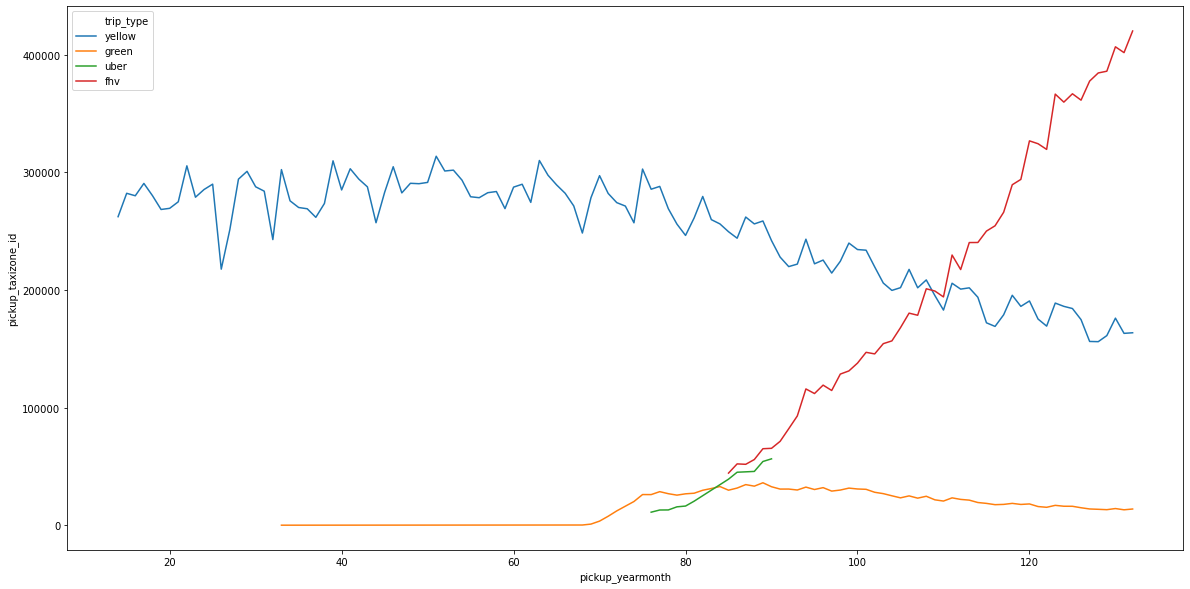

In [20]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x="pickup_yearmonth",
    y="pickup_taxizone_id",
    hue="trip_type",
    data=monthly[(monthly.pickup_yearmonth > 13) & (monthly.pickup_yearmonth < 133)]
)


In [ ]:
# we see that uber data overlaps with TLC's fhv data - one has to erase one of the sources to avoid duplicates